In [90]:
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
import skimage.io as io
from PIL import Image
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from skimage.exposure import histogram, cumulative_distribution
from skimage import img_as_ubyte, img_as_float
from scipy.stats import norm
from copy import deepcopy

Type of the image :  <class 'numpy.ndarray'>
Shape of the image : (128, 128, 3)
Hight of the image 128
Width of the image 128
Dimension of the Image 3


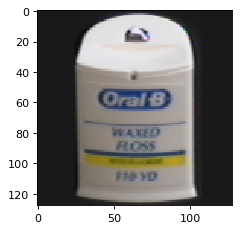

In [131]:
img = imread('archive/coil-100/coil-100/obj9__0.png')
plt.figure(num=None, figsize=(4, 3), dpi=80)
imshow(img)
#basic properties of image
print('Type of the image : ',type(img))
print('Shape of the image : {}'.format(img.shape))
print('Hight of the image {}'.format(img.shape[0]))
print('Width of the image {}'.format(img.shape[1]))
print('Dimension of the Image {}'.format(img.ndim)) 


We can see the shape of the image is three-layered and its width is 128, and the height of the image is 128. The type of image is an np array three-layered matrix.

In [138]:
#Check for the RGB values and size of the image
print('Image size {}'.format(img.size))
print('Maximum RGB value in this image {}'.format(img.max()))
print('Minimum RGB value in this image {}'.format(img.min())) 

Image size 49152
Maximum RGB value in this image 253
Minimum RGB value in this image 0


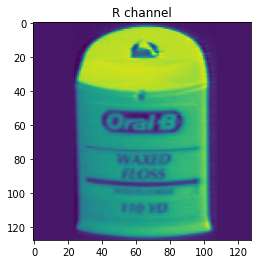

In [139]:
plt.title('R channel')
plt.imshow(img[ : , : , 0])
plt.show() 

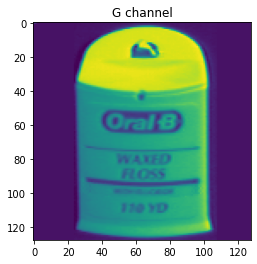

In [140]:
plt.title('G channel')
plt.imshow(img[ : , : , 1])
plt.show() 

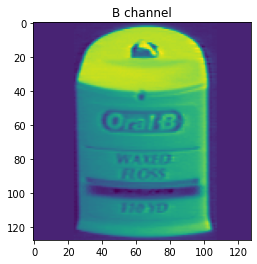

In [141]:
plt.title('B channel')
plt.imshow(img[ : , : , 2])
plt.show() 

In [145]:
green_img = np.zeros(img.shape)
green_img[:,:,1] = src[:,:,1]
print(green_img)

[[[ 0. 51.  0.]
  [ 0. 51.  0.]
  [ 0. 25.  0.]
  ...
  [ 0. 25.  0.]
  [ 0. 25.  0.]
  [ 0. 25.  0.]]

 [[ 0. 25.  0.]
  [ 0. 25.  0.]
  [ 0. 25.  0.]
  ...
  [ 0. 25.  0.]
  [ 0. 25.  0.]
  [ 0. 25.  0.]]

 [[ 0. 25.  0.]
  [ 0. 25.  0.]
  [ 0. 25.  0.]
  ...
  [ 0. 25.  0.]
  [ 0. 25.  0.]
  [ 0. 25.  0.]]

 ...

 [[ 0. 25.  0.]
  [ 0. 25.  0.]
  [ 0. 25.  0.]
  ...
  [ 0. 25.  0.]
  [ 0. 25.  0.]
  [ 0. 25.  0.]]

 [[ 0. 25.  0.]
  [ 0. 25.  0.]
  [ 0. 25.  0.]
  ...
  [ 0. 25.  0.]
  [ 0. 25.  0.]
  [ 0. 25.  0.]]

 [[ 0. 25.  0.]
  [ 0. 25.  0.]
  [ 0. 25.  0.]
  ...
  [ 0. 25.  0.]
  [ 0. 25.  0.]
  [ 0. 25.  0.]]]


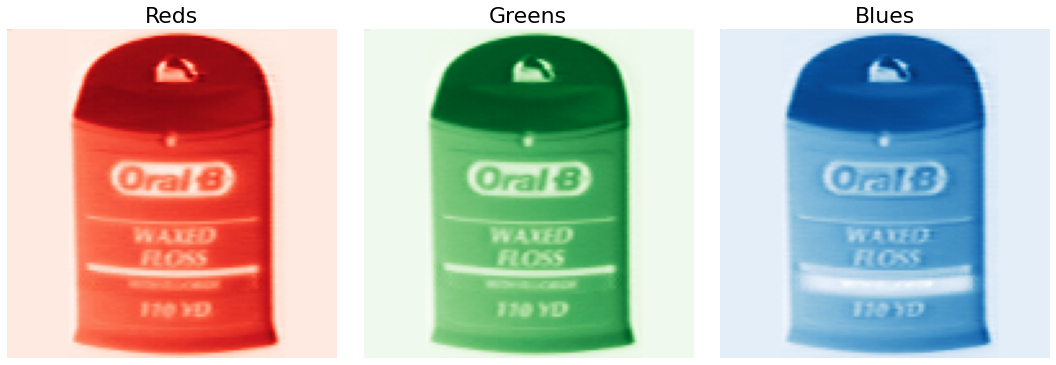

In [133]:
#split image RGB to 3 channels 
def rgb_splitter(image):
    rgb_list = ['Reds','Greens','Blues']
    fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey = True)
    for i in range(3):
        ax[i].imshow(image[:,:,i], cmap = rgb_list[i])
        ax[i].set_title(rgb_list[i], fontsize = 22)
        ax[i].axis('off')
    fig.tight_layout()
rgb_splitter(img)

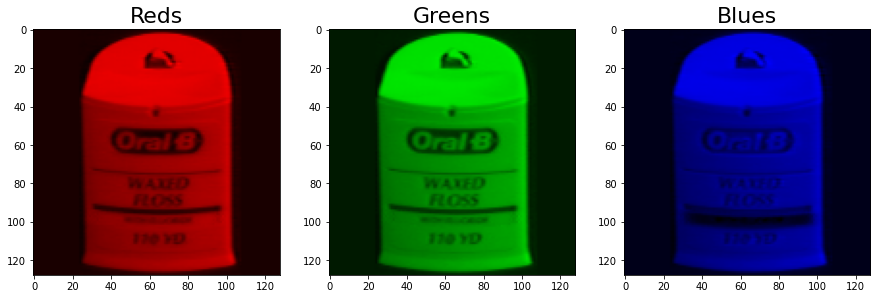

In [134]:
#split image RGB to 3 channels 
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))
rgb_list = ['Reds','Greens','Blues']
for c, ax in zip(range(3), ax):
    
    # create zero matrix
    split_img = np.zeros(img.shape, dtype="uint8") # 'dtype' by default: 'numpy.float64'
    
    # assing each channel 
    split_img[ :, :, c] = img[ :, :, c]
    
    # display each channel
    ax.set_title(rgb_list[c], fontsize = 22)
    ax.imshow(split_img)



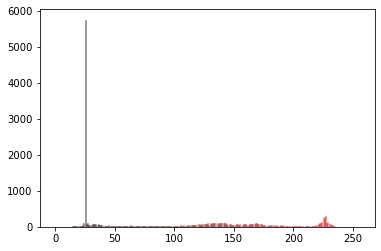

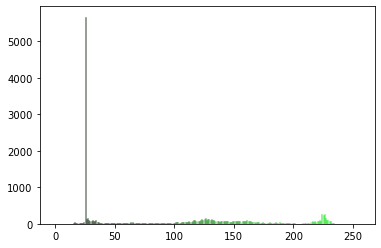

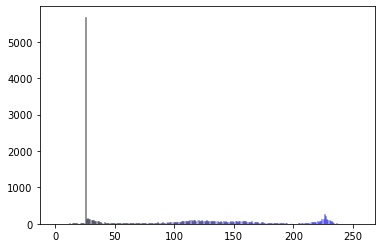

[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 5, 9, 13, 20, 18, 27, 16, 12, 22, 31, 52, 95, 5763, 91, 98, 64, 59, 47, 73, 66, 82, 67, 59, 71, 46, 54, 43, 40, 25, 27, 24, 34, 37, 24, 27, 24, 28, 33, 22, 34, 24, 24, 20, 23, 12, 18, 11, 15, 18, 14, 42, 14, 13, 20, 16, 12, 24, 22, 14, 11, 17, 16, 17, 22, 17, 17, 22, 17, 20, 22, 15, 17, 14, 22, 29, 22, 27, 20, 19, 22, 26, 25, 27, 29, 22, 24, 21, 23, 29, 25, 34, 32, 37, 30, 36, 38, 29, 34, 42, 31, 49, 44, 49, 62, 49, 51, 66, 69, 56, 69, 60, 67, 69, 75, 71, 97, 56, 94, 82, 106, 105, 102, 94, 104, 91, 110, 102, 97, 105, 107, 94, 81, 64, 69, 72, 53, 63, 58, 61, 73, 71, 51, 65, 48, 56, 65, 80, 71, 55, 57, 73, 74, 73, 71, 85, 92, 96, 78, 87, 69, 70, 64, 59, 44, 47, 33, 38, 35, 37, 49, 42, 27, 35, 41, 24, 35, 37, 28, 54, 28, 22, 19, 15, 7, 18, 11, 18, 18, 21, 9, 18, 12, 11, 9, 3, 9, 4, 10, 9, 9, 15, 16, 32, 33, 31, 30, 50, 64, 74, 94, 110, 145, 242, 278, 304, 113, 130, 76, 85, 48, 63, 23, 15, 5, 8, 1, 3, 2, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [148]:
def getRed(redVal):

    return '#%02x%02x%02x' % (redVal, 0, 0)

 

def getGreen(greenVal):

    return '#%02x%02x%02x' % (0, greenVal, 0)

   

def getBlue(blueVal):

    return '#%02x%02x%02x' % (0, 0, blueVal)

image = Image.open('archive/coil-100/coil-100/obj9__0.png')

# Modify the color of two pixels

image.putpixel((0,1), (1,1,5))

image.putpixel((0,2), (2,1,5))

 

# Display the image

image.show()

 

# Get the color histogram of the image

histogram = image.histogram()

 

# Take only the Red counts

l1 = histogram[0:256]

 

# Take only the Blue counts

l2 = histogram[256:512]

 

# Take only the Green counts

l3 = histogram[512:768]

 

plt.figure(0)

 

# R histogram

for i in range(0, 256):

    plt.bar(i, l1[i], color = getRed(i), edgecolor=getRed(i), alpha=0.3)

 

# G histogram

plt.figure(1)

for i in range(0, 256):

    plt.bar(i, l2[i], color = getGreen(i), edgecolor=getGreen(i),alpha=0.3)

 

 

# B histogram

plt.figure(2)

for i in range(0, 256):

    plt.bar(i, l3[i], color = getBlue(i), edgecolor=getBlue(i),alpha=0.3)

 

plt.show()
print(l1)

In [147]:
img_array = np.array(img)

print(img_array.shape)
print(img_array)

(128, 128, 3)
[[[53 51 32]
  [53 51 10]
  [25 25 25]
  ...
  [25 25 25]
  [25 25 25]
  [25 25 25]]

 [[25 25 25]
  [25 25 25]
  [25 25 25]
  ...
  [25 25 25]
  [25 25 25]
  [25 25 25]]

 [[25 25 25]
  [25 25 25]
  [25 25 25]
  ...
  [25 25 25]
  [25 25 25]
  [25 25 25]]

 ...

 [[25 25 25]
  [25 25 25]
  [25 25 25]
  ...
  [25 25 25]
  [25 25 25]
  [25 25 25]]

 [[25 25 25]
  [25 25 25]
  [25 25 25]
  ...
  [25 25 25]
  [25 25 25]
  [25 25 25]]

 [[25 25 25]
  [25 25 25]
  [25 25 25]
  ...
  [25 25 25]
  [25 25 25]
  [25 25 25]]]
